In [1]:
import pandas as pd
import numpy as np
import os,seaborn
from pandas import Series

from os.path import join, getsize

%matplotlib inline
import matplotlib.pyplot as plt

import sys

## 将路线分段

In [258]:
# 获取附件一中的所有文件路径
filepath = np.array([])
for root, dirs, files in os.walk('../all_data/附件1-全部数据-450辆车/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))
filepath = sorted(filepath)
print("\t".join(filepath[:3]))

../all_data/附件1-全部数据-450辆车/AA00001.csv	../all_data/附件1-全部数据-450辆车/AA00002.csv	../all_data/附件1-全部数据-450辆车/AA00004.csv


In [164]:
filepath[1]

'../data/submit_data/AB00006.csv'

In [267]:
# 加载数据

for j in range(1):
#     j = 1
#     vehicle = pd.read_csv(filepath[j])
    filepath = "../data/AD00003.csv"
    vehicle = pd.read_csv(filepath)

    vehicle['location_time'] = pd.to_datetime(vehicle['location_time'])

    # 计算时间戳的间隔
    time_diff = np.diff(vehicle["location_time"])/np.timedelta64(1, 's')
#     time_diff = np.insert(time_diff,0,0)
    time_diff = np.append(time_diff,0)

    vehicle['time_diff'] = time_diff 

    # 筛选出时间戳间隔大于5min的索引项 &(vehicle['gps_speed']==0)
    big_diff = (vehicle[(vehicle['time_diff']>1200)&((vehicle['acc_state']==0)|
                                            (vehicle['gps_speed']==0)|(vehicle['time_diff']>1800))].index+1).tolist()


    big_diff = sorted(big_diff)
    
    print("File name: {}".format(filepath.split("/")[-1]))
    print(big_diff)
    
    # 根据索引项将数据文件分段
    filename = filepath.split("/")[-1].split(".")[0]

#     vehicle[:big_diff[0]].to_csv("data/process_file/" + filename + "/" + filename + "_0.csv")

    for i in range(len(big_diff)-1):
        vehicle[big_diff[i]:big_diff[i+1]].to_csv("data/process_file/"+ filename + "/" + filename + "_" + str(i+1) +".csv")
    vehicle[big_diff[-1]:].to_csv("data/process_file/" + filename + "/" + filename + "_"+ str(len(big_diff)) +".csv")

File name: AD00003.csv
[4248, 5088, 16240, 35116, 37878, 38270, 38440, 54032, 54649, 55366, 57022, 57827, 58025, 58127, 58567, 59211, 59719, 60242, 60720, 60962, 61679, 61779, 62408, 62550]


In [268]:
len(big_diff)+1

25

- - - 

## 速度差值、方位角角度分析

### 单个车辆单线路的速度分布

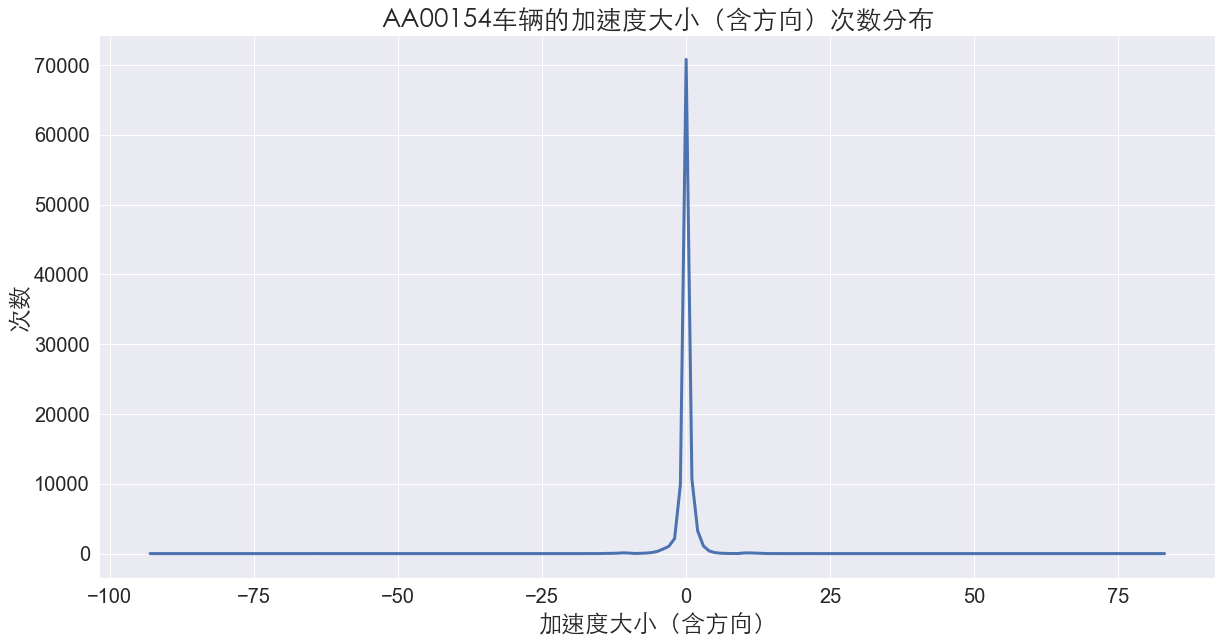

In [32]:
from collections import Counter

from matplotlib.font_manager import FontProperties
font=FontProperties(fname='STHeiti Light.ttc',size=10)

vehicle = pd.read_csv("../data/attachment_1_100/AA00154.csv")

speed_diff = np.diff(vehicle['gps_speed'])

speed = dict(Counter(speed_diff))

speed_keys = sorted(speed.keys())

values = [speed[key] for key in speed_keys]

# Set the global default size of matplotlib figures

plt.rc('figure', figsize=(20, 10))
# Set seaborn aesthetic parameters to defaults
seaborn.set()
    
plt.plot(speed_keys,values,linewidth=3)
plt.title("AA00154车辆的加速度大小（含方向）次数分布",fontproperties=font,fontsize=26)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("加速度大小（含方向）",fontproperties=font,fontsize=24)
plt.ylabel("次数",fontproperties=font,fontsize=24)

plt.savefig("image/AA00154车辆的加速度大小（含方向）次数分布.jpg",dpi=800)
plt.show()
plt.close()

### 将这些点进行均值处理

- - - 

In [58]:
### 统计空缺值

def find_missing_point(part_vehicle):
    """
    param:
        part_vehicle: a dataframe of vehicle,which contains (location_time,lng,lat) filed.
    return:
        res: complete point dataframe.
        lng_lat: 2-dimension numpy array.
        nan_index: missing data index in lng_lat(2-dimension numpy array.)
    """
    part_vehicle['location_time'] = pd.to_datetime(part_vehicle['location_time'])

    grouper = pd.Grouper(key='location_time', freq='1s')

    # res为补完点后的dataframe
    res = part_vehicle.groupby(grouper).first().reset_index()
    
    
    lng_lat = res[['lng','lat']].values
    isnull_state = np.isnan(lng_lat)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))
    
    return res,nan_index,lng_lat

In [266]:
from time import time
from pykalman import KalmanFilter

# 获取分段后的所有文件路径
filepath_miss = np.array([])
for root, dirs, files in os.walk('data/process_file/AB00006/'):
    filepath_miss = np.concatenate((filepath_miss,np.array([join(root, name) for name in files])))
filepath_miss = np.sort(filepath_miss)
print("\t".join(filepath_miss[:3]))

number = 0

for j in range(1):


    filepath = "../data/AD00003.csv"


    remove_vehicle = pd.read_csv(filepath)

    complete_vehicle,error_index,lng_lat = find_missing_point(remove_vehicle)
    

    number = len(error_index)

    filename = filepath.split("/")[-1].split(":")[0]
    print("No.{} vehivle missing point number: {}".format(filename,number))

data/process_file/AB00006/AB00006_0.csv	data/process_file/AB00006/AB00006_1.csv	data/process_file/AB00006/AB00006_10.csv
No.AD00003.csv vehivle missing point number: 6542170


### 利用经纬度坐标来判断离群点

In [195]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371.393 # 地球平均半径，单位为公里
    return c * r * 1000

In [4]:
def calculate_distance(filepath):
    """
    param:
        filepath: filepath of processing file.
    return:
        distance: distance of two point in this file.(a 3-D numpy array. length of array is length of dataframe-1)
                  distance = (filename, index, distance)
    """
    vehicle = pd.read_csv(filepath)
    filename = filepath.split("/")[-1].split(".")[0]
    
    distance = [(filename,i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                                 vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]

    return distance

In [50]:
def remove_outlier(filepath):
    
    test_vehicle = pd.read_csv(filepath)
    X_con = test_vehicle[['lng','lat']].values
    
    
    clf = IsolationForest(contamination=0.1,behaviour="new")
    clf.fit(X_con)
    y_pred_train = clf.predict(X_con)

    outlier_index = np.where(y_pred_train==-1)[0]
    
    if len(outlier_index):
        if outlier_index[0] == 0:
            outlier_index = np.delete(outlier_index,0)
    
    for index in outlier_index:
        X_con[index] = np.nan
    
#     print(outlier_index)
    test_vehicle[['lng','lat']] = X_con
    
    return test_vehicle

In [412]:
filepath = "data/correct_point/AD00003/AD00003_2.csv"
test_data = pd.read_csv(filepath)
test_lng_lat = test_data[['lng','lat']].values
remove_outlier(filepath)

[1291 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303 1304 1305
 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319
 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347
 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361
 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375
 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389
 1390 1391 1392 1393 1394 1395 1396 1397 1398 1399 1400 1401 1402 1403
 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417
 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431
 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445
 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459
 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473
 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487
 1488 

,Unnamed: 0,location_time,Unnamed: 0.1,vehicleplatenumber,device_num,direction_angle,lng,lat,acc_state,right_turn_signals,left_turn_signals,hand_brake,foot_brake,gps_speed,mileage,time_diff
0,0,2018-08-05 23:58:55,8354.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,1955.0
1,1,2018-08-05 23:58:56,NaN,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,NaN
2,2,2018-08-05 23:58:57,NaN,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,NaN
3,3,2018-08-05 23:58:58,NaN,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,NaN
4,4,2018-08-05 23:58:59,8356.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,4.0
5,5,2018-08-05 23:59:00,8358.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,1.0
6,6,2018-08-05 23:59:01,8360.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,1.0
7,7,2018-08-05 23:59:02,8362.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,1.0
8,8,2018-08-05 23:59:03,8364.0,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,1.0
9,9,2018-08-05 23:59:04,NaN,AD00003,AAA7109003,267.0,115.132953,27.207653,1.0,0.0,0.0,0.0,0.0,0.0,5673.0,NaN


In [416]:
dedede = np.where(test_lng_lat[:,0]>115.4)[0]
dedede

array([1289, 1290, 1291, ..., 5850, 5851, 5852])

In [417]:
len(dedede)/len(test_lng_lat)

0.13740112994350281

### 补点

In [48]:
def add_point(part_vehicle):
    """
    param:
        part_vehicle: a dataframe of vehicle,which contains (location_time,lng,lat) filed.
    return:
        res: complete point dataframe.
        lng_lat: 2-dimension numpy array.
        nan_index: missing data index in lng_lat(2-dimension numpy array.)
    """
    part_vehicle['location_time'] = pd.to_datetime(part_vehicle['location_time'])

    grouper = pd.Grouper(key='location_time', freq='1s')

    res为补完点后的dataframe
    res = part_vehicle.groupby(grouper).first().reset_index()
    
    lng_lat = res[['lng','lat']].values
    isnull_state = np.isnan(lng_lat)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))
    
    return res,nan_index,lng_lat

### 尝试使用kalman算法进行补点及光滑线路

In [54]:
def kalman_em_smoothing(lng_lat,masked_index):
    """
    param：
        lng_lat: a 2-dimension numpy array.(longitude,latitude)
        masked_index: the index of missing point in lng_lat array
    return:
        lng and lat of correct point.(a 2-dimension numpy array) 
    """
    lng_lat_missing = np.ma.array(lng_lat, mask=np.zeros(lng_lat.shape))
        
    for i in masked_index:
        lng_lat_missing[i] = np.ma.masked

    # specify parameters
    observation_matrix = np.array([lng_lat[0],lng_lat[-1]])

    initial_state_mean = lng_lat[0]
    n_timesteps = 50

    kf = KalmanFilter(initial_state_mean=initial_state_mean,n_dim_obs=2)

    correct_point = kf.em(lng_lat_missing,n_iter=10).smooth(lng_lat_missing)[0]
    
    return correct_point

### 将其他字段进行填充

In [86]:
def complete_other_filed(res):
    """
    param:
        res: a dataframe.
    return:
        res: a dataframe with completed data item
    """
    gps_speed = res['gps_speed'].values
    other_filed = res[['vehicleplatenumber','device_num','direction_angle','acc_state','right_turn_signals',
                     'left_turn_signals','hand_brake','foot_brake','mileage']].values
    
    isnull_state = np.isnan(gps_speed)
    nan_index = np.array(sorted(list(set(np.where(isnull_state)[0]))))

    for i in nan_index:
        other_filed[i] = other_filed[i-1]
        if np.isnan(gps_speed[i+1]):
            gps_speed[i] = gps_speed[i-1]
        else:
            gps_speed[i] = np.mean([gps_speed[i-1],gps_speed[i+1]],axis=0)
    
    res['gps_speed'] = gps_speed
    res[['vehicleplatenumber','device_num','direction_angle','acc_state','right_turn_signals',
                     'left_turn_signals','hand_brake','foot_brake','mileage']] = other_filed
    
    return res

- - -

In [271]:
# 获取分段后的所有文件路径
filepaths = np.array([])
for root, dirs, files in os.walk('data/process_file/AD00003/'):
    filepaths = np.concatenate((filepaths,np.array([join(root, name) for name in files])))
print("\n".join(sorted(filepaths)[:3]))

data/process_file/AD00003/AD00003_1.csv
data/process_file/AD00003/AD00003_10.csv
data/process_file/AD00003/AD00003_11.csv


In [272]:
from time import time
from pykalman import KalmanFilter

start_time = time()

for j in range(len(filepaths)):
    
    filepath = "data/process_file/AD00003/AD00003_" + str(j) +".csv"
    

#     point_distance = calculate_distance(filepath)
#     remove_vehicle,filename,err_index = remove_drift_point(filepath,point_distance)


    first_correct_vehicle = remove_outlier(filepath)
#     first_correct_vehicle = pd.read_csv(filepath)
    complete_vehicle,error_index,lng_lat = add_point(first_correct_vehicle)

    complete_vehicle = complete_other_filed(complete_vehicle)

    filename = filepath.split("/")[-1].split(".")[0]
    print("filename: {}".format(filename),end="\t")
    
    # kalman filter
    power_point = kalman_em_smoothing(lng_lat,error_index)


    complete_vehicle[['lng','lat']] = power_point
    complete_vehicle.to_csv("data/correct_point/" + filename.split("_")[0] + "/" + filename + ".csv")
    
stop_time = time()
print("time spent：{}s".format(stop_time-start_time))

FileNotFoundError: [Errno 2] File b'data/process_file/AD00003/AD00003_0.csv' does not exist: b'data/process_file/AD00003/AD00003_0.csv'

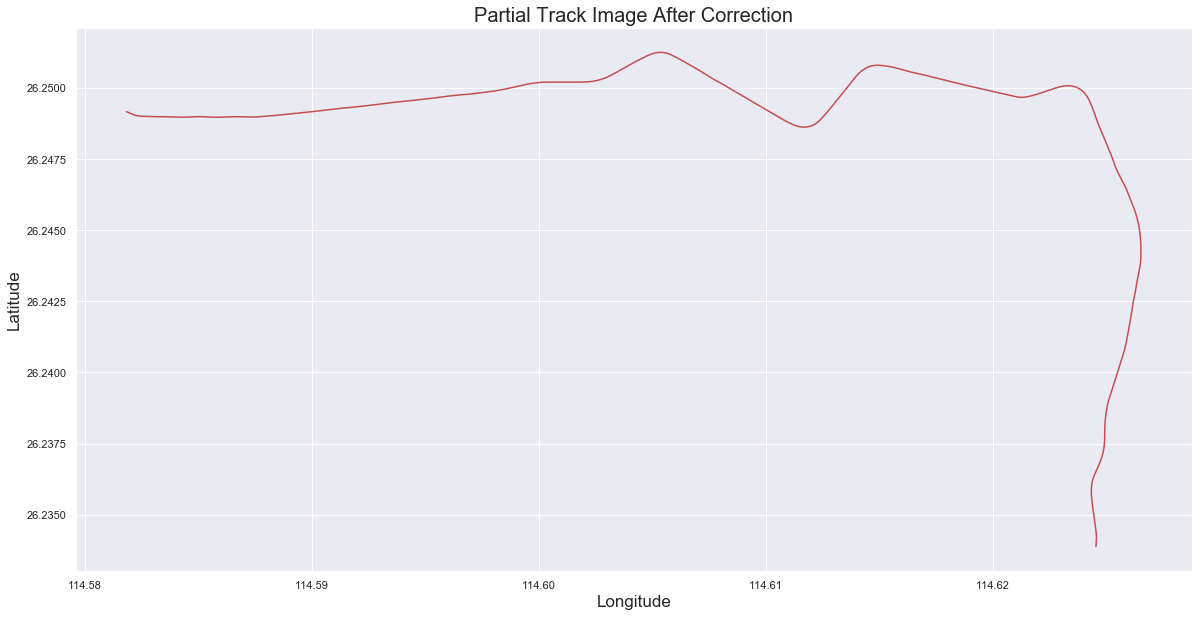

In [356]:
plt.rc('figure', figsize=(20, 10))
seaborn.set()

plt.plot(power_point[:,0],power_point[:,1],c='r')

plt.title("Partial Track Image After Correction", fontsize=20)
plt.xlabel("Longitude",fontsize=17)
plt.ylabel("Latitude",fontsize=17)
plt.savefig("image/distance_image_after/" + filepath.split("/")[-1].split(".")[0] + ".jpg")
plt.show()
plt.close()

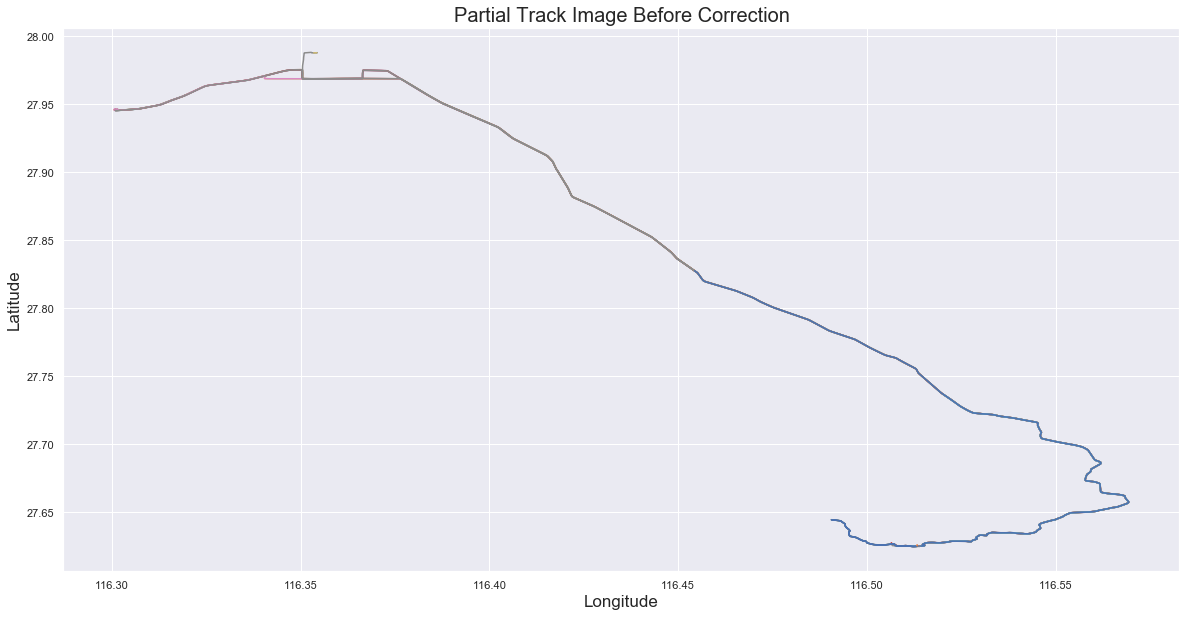

In [182]:
# 用来画全部的图的


filepath = np.array([])
for root, dirs, files in os.walk('data/correct_point/AF00373/'):
    filepath = np.concatenate((filepath,np.array([join(root, name) for name in files])))

plt.rc('figure', figsize=(20, 10))
seaborn.set()

plt.title("Partial Track Image Before Correction", fontsize=20)
plt.xlabel("Longitude",fontsize=17)
plt.ylabel("Latitude",fontsize=17)

# AB00006
# remove_route = [0,3,4,5,6,8,11,13,15,20,26,28]
# AD00053
# remove_route = [12]
# AF00373
remove_route = [12,13,14]
    
for j in range(len(filepath)):
    if j in remove_route:
        continue
    file = "data/correct_point/AF00373/AF00373_" + str(j) + ".csv"
    eeee1 = pd.read_csv(file)
    eres1 = eeee1[['lng','lat']].values
    
    plt.plot(eres1[:,0],eres1[:,1])
#     plt.savefig("selection_image/AB00006/" + file.split('/')[-1].split('.')[0] + ".jpg")
plt.show()

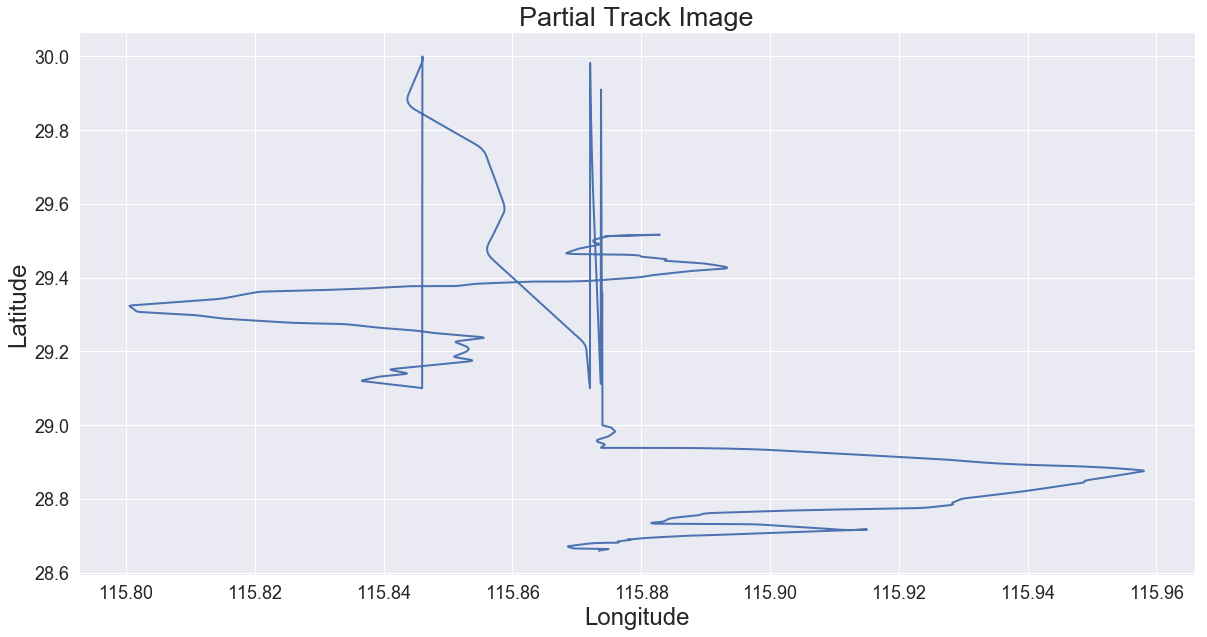

In [38]:
plt.rc('figure', figsize=(20, 10))
seaborn.set()

# correct_point = pd.read_csv("data/correct_point/AD00003/AD00003_0.csv")
# correct = correct_point[['lng','lat']].values
correct_point2 = pd.read_csv("data/process_file/AA00004/AA00004_3.csv")
correct2 = correct_point2[['lng','lat']].values

# correct = np.concatenate((correct,correct2))

plt.plot(correct2[:,0],correct2[:,1],linewidth=2)

plt.title("Partial Track Image", fontsize=27)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel("Longitude",fontsize=24)
plt.ylabel("Latitude",fontsize=24)
plt.savefig("image/AA00004_3_before.jpg",dpi=800)
plt.show()

#### 对重复项去重，并保留第一个出现的项

### 对数据进行测试

- - -

### Main:利用经纬度坐标计算行车里程。

In [107]:
all_point_distance = np.array([[0,0,0]])

for j in range(len(filepath)):

    vehicle = pd.read_csv(filepath[j])

    filename = filepath[j].split("/")[-1].split(".")[0]
    
    distance = [(filename,i,haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                                 vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"])) for i in range(len(vehicle)-1)]
    
    sum_distance = sum(all_point_distance[:,2].astype('float'))
    print("{}'s mileage：{:.3f}km".format(filename,sum_distance/1000))
    all_point_distance = np.concatenate((all_point_distance,distance))
    

all_point_distance = np.delete(all_point_distance,0,axis=0)

# 每秒最大的距离
# max_distance_mil = max(list(set(vehicle["gps_speed"])))/3.6

sum_distance = sum(all_point_distance[:,2].astype('float'))
print("Total mileage：{:.3f}km".format(sum_distance/1000))

Total mileage：700.993km


In [247]:
def calculate_mileage(vehicle):
    
    
    distance = [haversine(vehicle.iloc[i+1]["lng"],vehicle.iloc[i+1]["lat"],
                                    vehicle.iloc[i]["lng"],vehicle.iloc[i]["lat"]) for i in range(len(vehicle)-1)]
    
    sum_distance = sum(distance)

    return sum_distance

In [260]:
# 获取要提交的路线后的所有文件路径
submit_filepath = np.array([])
for root, dirs, files in os.walk('test_data/'):
    submit_filepath = np.concatenate((submit_filepath,np.array([join(root, name) for name in files])))
print("\n".join(sorted(submit_filepath)[:3]))

test_data/AA00002_0.csv
test_data/AA00002_1.csv
test_data/AA00002_2.csv


In [261]:
all_distance_info = np.array([[0,0,0,0,0,0]])
for j in sorted(submit_filepath):
    
    vehicle = pd.read_csv(j)
    
    filename = j.split("/")[-1].split(".")[0]
    
    
    # 计算时间戳的间隔
    time_diff = np.diff(pd.to_datetime([vehicle["location_time"][0],
                                        vehicle["location_time"][len(vehicle)-1]]))/np.timedelta64(1, 's')

    # 计算行车里程
    mileage = calculate_mileage(vehicle)
    
    # 计算行车速度
    average_speed = mileage/time_diff

    # 统计急加速次数
    speed_diff = np.diff(vehicle['gps_speed']).tolist()
    speed_diff.append(0)

    rapidly_accle = [(i,speed_diff[i]/3.6) for i in range(len(speed_diff)) if speed_diff[i]/3.6>3]
    rapidly_slow = [(i,speed_diff[i]/3.6) for i in range(len(speed_diff)) if speed_diff[i]/3.6<-3]
    
    vehicle_number = filename.split("_")[0]
#     print("{} route have been processed".format(filename))
    
    all_distance_info = np.concatenate((all_distance_info,np.array
                                        ([[vehicle_number,filename,round(mileage/1000,2),round(average_speed[0],2),len(rapidly_accle),len(rapidly_slow)]])))
    
all_distance_info = np.delete(all_distance_info,0,axis=0)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


In [262]:
all_info = pd.DataFrame(all_distance_info,columns=["vehicle_number",
                    "route_number","mileage(km)","average speed(m/s)","rapidly accelerate times","rapidly slow times"])
all_info.to_csv("submit_vehicle_info2.csv")

In [244]:
vehicle = pd.read_csv(submit_filepath[0])

speed_diff = np.diff(vehicle['gps_speed']).tolist()
speed_diff.append(0)

rapidly_accle = [(i,speed_diff[i]/3.6) for i in range(len(speed_diff)) if speed_diff[i]/3.6>3]
rapidly_slow = [(i,speed_diff[i]/3.6) for i in range(len(speed_diff)) if speed_diff[i]/3.6<-3]

accle = dict(Counter(rapidly_accle))

print("其中急加速次数为{}次,具体情况如下{},急减速次数为{}次".format(len(rapidly_accle),accle,len(rapidly_slow)))

其中急加速次数为32次,具体情况如下{(197, 3.0555555555555554): 1, (202, 3.333333333333333): 1, (1714, 3.0555555555555554): 1, (2167, 3.0555555555555554): 1, (2474, 3.0555555555555554): 1, (2623, 3.333333333333333): 1, (2678, 3.333333333333333): 1, (4696, 3.333333333333333): 1, (5416, 3.0555555555555554): 1, (5604, 3.611111111111111): 1, (6267, 3.333333333333333): 1, (6953, 3.333333333333333): 1, (7658, 3.0555555555555554): 1, (8500, 3.0555555555555554): 1, (8519, 3.0555555555555554): 1, (8809, 3.0555555555555554): 1, (9553, 3.0555555555555554): 1, (9571, 3.0555555555555554): 1, (10616, 3.611111111111111): 1, (11982, 3.333333333333333): 1, (12426, 3.333333333333333): 1, (12818, 3.888888888888889): 1, (13733, 3.0555555555555554): 1, (15539, 3.611111111111111): 1, (15546, 3.0555555555555554): 1, (15678, 3.333333333333333): 1, (15807, 3.333333333333333): 1, (16387, 3.0555555555555554): 1, (16526, 3.0555555555555554): 1, (16574, 3.888888888888889): 1, (16770, 3.0555555555555554): 1, (16772, 3.05555555555555